# Лабораторная работа №5. Интегрирование.

In [71]:
import matplotlib.pyplot as plt
import math
import numpy

In [69]:
def MakeDiagonal(A, f):
    for rowIndex in range(len(A)-1, -1, -1):
        columnIndex = rowIndex

        # Уже сделали это в MakeUpDiagonal.
        #f[rowIndex] /= A[rowIndex][columnIndex]
        #A[rowIndex][columnIndex] = 1

        for _rowIndex in range(0, rowIndex):
            f[_rowIndex] -= f[rowIndex] * A[_rowIndex][columnIndex]
            A[_rowIndex][columnIndex] = 0

def MakeUpDiagonal(A, f, findMaxElem):
    for columnIndex in range(0, len(A)):
        rowIndex = columnIndex
        
        # Ищем максимальный элемент.
        if (findMaxElem):
            maxRowIndex = rowIndex
            maxElem = A[rowIndex][columnIndex]
            for _rowIndex in range(rowIndex + 1, len(A)):
                # Если главный элемент равен 0, его нужно заменить.
                if (A[_rowIndex][columnIndex] != 0 and
                    (A[_rowIndex][columnIndex] > maxElem or
                     maxElem == 0)):
                    maxElem = A[_rowIndex][columnIndex]
                    maxRowIndex = _rowIndex
            if (rowIndex != maxRowIndex):
                # Меняем строки местами.
                A[[rowIndex, maxRowIndex]] = A[[maxRowIndex, rowIndex]]
                f[[rowIndex, maxRowIndex]] = f[[maxRowIndex, rowIndex]]

        # Прямой ход метода Гаусса.

        # Делаем диагональный элемент равным 1.
        a = A[rowIndex][columnIndex]
        A[rowIndex] /= a
        f[rowIndex] /= a
        # Присваиваем точное значение, из-за возможной ошибки при округлении.
        A[rowIndex][columnIndex] = 1
        # Обнуляем элементы под диагональным.
        for _rowIndex in range(rowIndex + 1, len(A)):
            f[_rowIndex] -= f[rowIndex] * A[_rowIndex][columnIndex]
            A[_rowIndex] -= A[rowIndex] * A[_rowIndex][columnIndex]
            # Присваиваем точное значение, из-за возможной ошибки при округлении.
            A[_rowIndex][columnIndex] = 0
 
# Решает систему линейных уравнений Ax = f методом Гаусса. 
# Внимание! Изменяет исходные значения A и f.
def SolveGauss(A, f, findMaxElem = True):
    MakeUpDiagonal(A, f, findMaxElem)
    MakeDiagonal(A, f)
    return f

In [70]:

class Spline:
    def __init__(self, x, f):
        def FunctEq(A, b, i, rowIndex, x_i, f_i):
            columnIndex = 4 * i
            # a_i
            A[rowIndex[0]][columnIndex]     = x_i**3
            # b_i
            A[rowIndex[0]][columnIndex + 1] = x_i**2
            # c_i
            A[rowIndex[0]][columnIndex + 2] = x_i
            # d_i
            A[rowIndex[0]][columnIndex + 3] = 1

            b[rowIndex[0]] = f_i
            rowIndex[0] += 1
        
        def FunctDerEq(A, b, i, rowIndex, x_i):
            columnIndex = 4 * i
            # a_i
            A[rowIndex[0]][columnIndex]     = 3 * x_i**2
            # b_i
            A[rowIndex[0]][columnIndex + 1] = 2 * x_i
            # c_i
            A[rowIndex[0]][columnIndex + 2] = 1

            # a_i+1
            A[rowIndex[0]][columnIndex + 4] = -3 * x_i**2
            # b_i+1
            A[rowIndex[0]][columnIndex + 5] = -2 * x_i
            # c_i+1
            A[rowIndex[0]][columnIndex + 6] = -1

            b[rowIndex[0]] = 0
            rowIndex[0] += 1

        def FunctDer2Eq(A, b, i, rowIndex, x_i):
            columnIndex = 4 * i
            # a_i
            A[rowIndex[0]][columnIndex]     = 6 * x_i
            # b_i
            A[rowIndex[0]][columnIndex + 1] = 2

            # a_i+1
            A[rowIndex[0]][columnIndex + 4] = -6 * x_i
            # b_i+1
            A[rowIndex[0]][columnIndex + 5] = -2

            b[rowIndex[0]] = 0
            rowIndex[0] += 1

        def FunctDer2Eq0(A, b, i, rowIndex, x_i):
            columnIndex = 4 * i
            # a_i+1
            A[rowIndex[0]][columnIndex]     = 6 * x_i
            # b_i+1
            A[rowIndex[0]][columnIndex + 1] = 2

            b[rowIndex[0]] = 0
            rowIndex[0] += 1

        # P_3(x) = ax^3 + bx^2 + cx + d.
        # a1, b1, c1, d1, a2, b2, c2, d2, ..., an, bn, cn, dn.
        n = len(x) - 1
        A = numpy.zeros((4*n, 4*n))
        b = numpy.empty(4 * n)

        rowIndex = [0]
        # Равенство значений кубических интерполянтов в точках
        FunctEq(A, b, 0, rowIndex, x[0], f[0])
        for i in range(1, len(x) - 1):
            FunctEq(A, b, i-1, rowIndex, x[i], f[i])
            FunctEq(A, b, i, rowIndex, x[i], f[i])
        FunctEq(A, b, n - 1, rowIndex, x[len(x) - 1], f[len(x) - 1])

        # Равенство первых производных
        for i in range(1, len(x) - 1):
            FunctDerEq(A, b, i-1, rowIndex, x[i])
        
        # Равенство вторых производных
        for i in range(1, len(x) - 1):
            FunctDer2Eq(A, b, i-1, rowIndex, x[i])
        
        FunctDer2Eq0(A, b, 0, rowIndex, x[0])
        FunctDer2Eq0(A, b, n - 1, rowIndex, x[len(x) - 1])

        self.coefs = SolveGauss(A, b)
        self.x = x

    def Interpolate(self, x):
        def Calc(coefs, i, x):
            startI = 4 * i
            return coefs[startI] * x**3 + coefs[startI + 1] * x**2 + coefs[startI + 2] * x + coefs[startI + 3]
        
        if (x <= self.x[0]):
            return Calc(self.coefs, 0, x)
        elif (x >= self.x[len(self.x) - 2]):
            return Calc(self.coefs, len(self.x) - 2, x)
        else:
            for st in range(0, len(self.x) - 1):
                if (self.x[st] <= x and x <= self.x[st + 1]):
                    return Calc(self.coefs, st, x)
                

In [52]:
def IntegrateTrapezoid(x, f):
    step = x[1] - x[0]
    integral = 1/2 * (f[0] + f[len(f) - 1])
    for st in range(1, len(f) - 1):
        integral += f[st]
    return step * integral

def IntegrateSimpson(x, f):
    step = x[1] - x[0]
    integral = f[0] + f[len(f) - 1]
    for st in range(1, len(f) - 1):
        if (st % 2 == 1):
            integral += 4 * f[st]
        else:
            integral += 2 * f[st]
    return 1/3 * step * integral

# p - порядок функции integrationMethod
def IntegrateRichardson(x, f, integrationMethod, p):
    assert (len(x) % 2 == 1)

    x2 = []
    f2 = []
    for st in range(0, len(x), 2):
        x2.append(x[st])
        f2.append(f[st])

    Ih  = integrationMethod(x, f)
    I2h = integrationMethod(x2, f2)
    
    return Ih + (Ih - I2h) / (2**p - 1)

### Интегрирование параболы

Точное значение:
	I = 16.129148629148627
Метод трапеции:
	I = 16.199
Метод Симпсона:
	I = 16.129148629148624
Метод трапеции, экстраполяция Ричардсона:
	I = 16.129148629148631


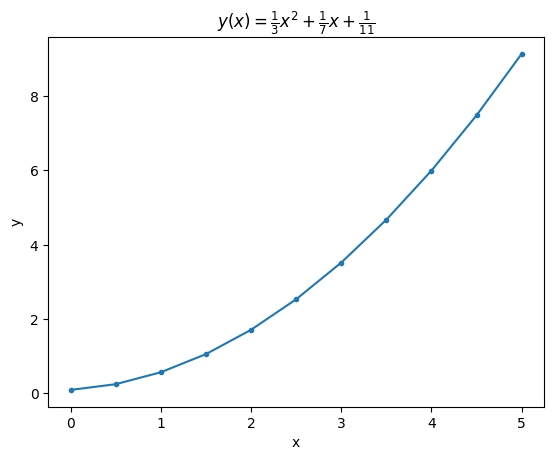

In [62]:
def parabola(x):
    return 1/3*x**2 + 1/7*x +1/11

def parabolaF(x):
    return 1/9 * x**3 + 1/14 * x**2 + 1/11 * x

x1 = 0
x2 = 5
x = numpy.array(list(numpy.arange(x1, x2, (x2 - x1) / 10)) + [x2])
y = parabola(x)
I1 = IntegrateTrapezoid(x, y)
I2 = IntegrateSimpson(x, y)
I3 = IntegrateRichardson(x, y, IntegrateTrapezoid, 2)
I4 = parabolaF(x2) - parabolaF(x1)

print("Точное значение:\n\tI = {:.15f}".format(I4))
print("Метод трапеции:\n\tI = {:.3f}".format(I1))
print("Метод Симпсона:\n\tI = {:.15f}".format(I2))
print("Метод трапеции, экстраполяция Ричардсона:\n\tI = {:.15f}".format(I3))

plt.plot(x, y, marker = '.')
plt.title(r"$y(x) = \frac{1}{3}x^2 + \frac{1}{7}x +\frac{1}{11}$")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### VII.9.5(б)

| x | f(x) |
|---|------|
| 0.000 | 0.000000 |
| 0.125 | 0.021470 |
| 0.250 | 0.293050 |
| 0.375 | 0.494105 |
| 0.500 | 0.541341 |
| 0.625 | 0.516855 |
| 0.750 | 0.468617 |
| 0.875 | 0.416531 |
| 1.000 | 0.367879 |

Метод трапеции, h:
	I = 0.36698856
Метод трапеции, 2h:
	I = 0.37173687
Метод Симпсона:
	I = 0.36540579166666665
Метод трапеции, экстраполяция Ричардсона:
	I = 0.36540579166666670


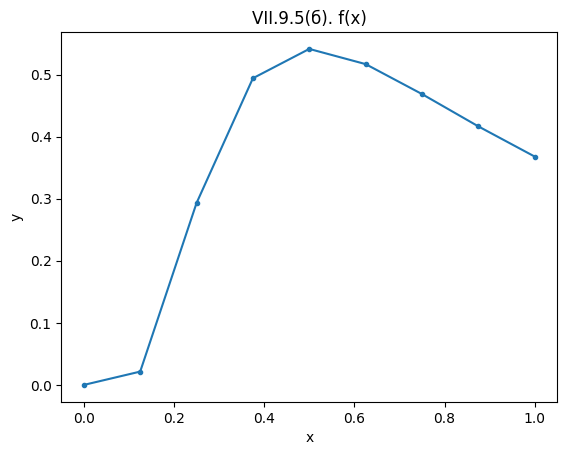

In [103]:
x = [0, 0.125, 0.250, 0.375, 0.500, 0.625, 0.750, 0.875, 1.000]
f = [0.000000, 0.021470, 0.293050, 0.494105, 0.541341, 0.516855, 0.468617, 0.416531, 0.367879]

x2 = []
f2 = []
for st in range(0, len(x), 2):
    x2.append(x[st])
    f2.append(f[st])

I2h = IntegrateTrapezoid(x2, f2)

I_tr = IntegrateTrapezoid(x, f)
I_tr_r = IntegrateRichardson(x, f, IntegrateTrapezoid, 2)
I_sm = IntegrateSimpson(x, f)

print("Метод трапеции, h:\n\tI = {:.8f}".format(I_tr))
print("Метод трапеции, 2h:\n\tI = {:.8f}".format(I2h))
print("Метод Симпсона:\n\tI = {:.17f}".format(I_sm))
print("Метод трапеции, экстраполяция Ричардсона:\n\tI = {:.17f}".format(I_tr_r))

plt.plot(x, f, marker = '.')
plt.title("VII.9.5(б). f(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### VII.9.13 (д)

$$
I = \int_0^4 f(x) \sin{30x} dx
$$

| x | f |
|---|---|
| 0 | 1 |
| 1 | 1.5403 |
| 2 | 1.5839 |
| 3 | 2.0100 |
| 4 | 3.3464 |

Количество точек = 50
	Метод трапеции:
		I = -0.02517090
	Метод Симпсона:
		I = -0.08800729179767908
	Метод трапеции, экстраполяция Ричардсона:
		I = -0.08800729179767895
Количество точек = 100
	Метод трапеции:
		I = -0.04929516
	Метод Симпсона:
		I = -0.05733657996555561
	Метод трапеции, экстраполяция Ричардсона:
		I = -0.05733657996555559
Количество точек = 1000
	Метод трапеции:
		I = -0.05642335
	Метод Симпсона:
		I = -0.05649361903680990
	Метод трапеции, экстраполяция Ричардсона:
		I = -0.05649361903680974
Количество точек = 10000
	Метод трапеции:
		I = -0.05649285
	Метод Симпсона:
		I = -0.05649354925848515
	Метод трапеции, экстраполяция Ричардсона:
		I = -0.05649354925848544


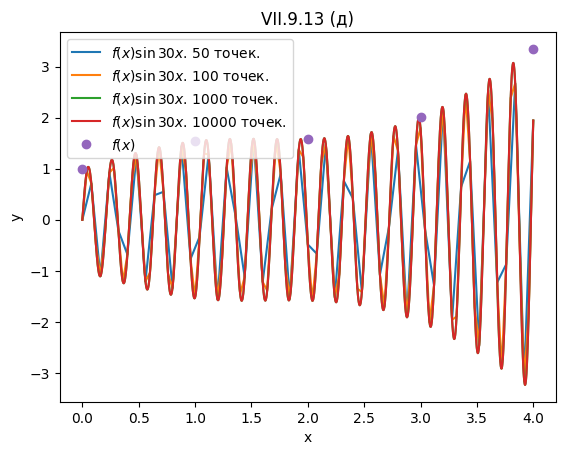

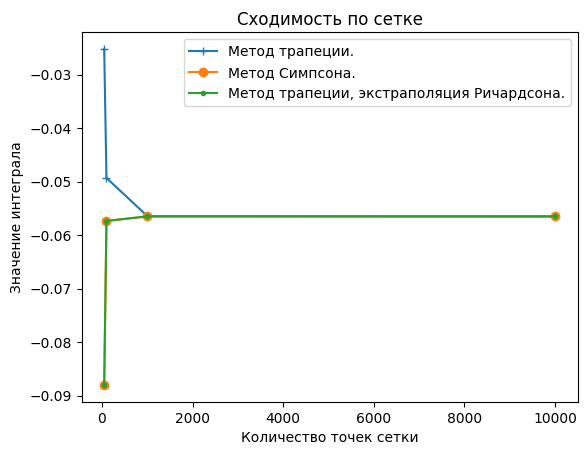

In [102]:
x0 = [0, 1, 2, 3, 4]
f = [1, 1.5403, 1.5839, 2.0100, 3.3464]
spl = Spline(x0, f)

def funct(spl : Spline, x):
    return spl.Interpolate(x) * math.sin(30 * x)

x1 = 0
x2 = 4

count = [50, 100, 1000, 10000]

I1 = []
I2 = []
I3 = []

for c in count:
    x = numpy.array(list(numpy.arange(x1, x2, (x2 - x1) / c)) + [x2])
    y = [funct(spl, _x) for _x in x]

    _I1 = IntegrateTrapezoid(x, y)
    _I2 = IntegrateSimpson(x, y)
    _I3 = IntegrateRichardson(x, y, IntegrateTrapezoid, 2)

    print("Количество точек = {}".format(c))
    print("\tМетод трапеции:\n\t\tI = {:.8f}".format(_I1))
    print("\tМетод Симпсона:\n\t\tI = {:.17f}".format(_I2))
    print("\tМетод трапеции, экстраполяция Ричардсона:\n\t\tI = {:.17f}".format(_I3))

    plt.plot(x, y, label = "$f(x) \sin{{30x}}$. {} точек.".format(c))

    I1.append(_I1)
    I2.append(_I2)
    I3.append(_I3)

I1 = numpy.array(I1)
I2 = numpy.array(I2)
I3 = numpy.array(I3)

plt.plot(x0, f, linestyle = "", marker = "o", label = "$f(x)$")
plt.title("VII.9.13 (д)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()
plt.clf()

plt.plot(count, I1, marker = "+", label = "Метод трапеции.")
plt.plot(count, I2, marker = "o", label = "Метод Симпсона.")
plt.plot(count, I3, marker = ".", label = "Метод трапеции, экстраполяция Ричардсона.")
plt.title("Сходимость по сетке")
plt.xlabel("Количество точек сетки")
plt.ylabel("Значение интеграла")
plt.legend()
plt.show()